# SAM3 远程无 GUI 两阶段分割（机械臂 + gripper 新 obj_id）

本 notebook 面向远程服务器（无 GUI）逐 cell 交互执行：

- 阶段 A：先做一次普通传播（bootstrap）填充缓存，再进行机械臂 points/labels refinement。
- 阶段 B：在关键帧使用 points + point_labels + **全新 obj_id** 新增 gripper，再传播。
- 导出支持对象集合选择：`arm-only` / `gripper-only` / `union` / `custom`。

> 注意：本 notebook 使用 inline 可视化与日志打印，不依赖 `%matplotlib widget`、按钮、鼠标事件回调。

In [1]:
import os
import glob
from pathlib import Path

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

import sam3
from sam3.model_builder import build_sam3_video_predictor
from sam3.visualization_utils import prepare_masks_for_visualization, visualize_formatted_frame_output

plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12

# ==============================
# 关键配置区（建议仅修改本区）
# ==============================

# 1) 路径配置
VIDEO_PATH = "/data/haoxiang/data/airexo2/task_0013/train/scene_0001/cam_105422061350/color"
CHECKPOINT_PATH = "/data/haoxiang/sam3/models/facebook/sam3/sam3.pt"

# 2) 推理配置
CUDA_VISIBLE_DEVICES = "0,1,2,3"
APPLY_TEMPORAL_DISAMBIGUATION = False
PROPAGATION_DIRECTION_STAGE_A = "forward"  # 建议 forward
PROPAGATION_DIRECTION_STAGE_B = "forward"  # 关键帧新增对象后再 forward

# 3) 对象 ID 配置
ARM_OBJ_IDS = [0]      # 机械臂已有对象集合（可多个）
GRIPPER_OBJ_ID = 2     # gripper 新对象 ID（必须与 ARM_OBJ_IDS 不冲突）

# 4) 阶段 A：bootstrap 文本提示 + 机械臂 points refinement
# 为避免首次 points add_prompt 触发 cached outputs 断言，必须先进行一次普通传播
ARM_BOOTSTRAP_TEXT_PROMPT = ""                # 建议填写，如 "robot arm"；留空时会按规则自动兜底
ARM_BOOTSTRAP_FALLBACK_TEXT_PROMPT = "robot arm"  # ARM_BOOTSTRAP_TEXT_PROMPT 为空时使用
ARM_BOOTSTRAP_FRAME_INDEX = None              # None=自动取首个 arm prompt 帧；若无 arm prompt 则使用 0

# 5) 阶段 A：机械臂初始提示（配置化 points，可为空）
# coord_type: "abs"(像素坐标) / "rel"([0,1]归一化坐标)
ARM_INITIAL_PROMPTS = [
    {
        "frame_index": 120,
        "obj_id": 0,
        "coord_type": "abs",
        "points": [[962, 350]],
        "labels": [0],
    }
]

# 6) 阶段 B：关键帧新增 gripper（points + point_labels + 新 obj_id）
# 支持多关键帧，通常 obj_id 使用同一个 GRIPPER_OBJ_ID
GRIPPER_KEYFRAME_PROMPTS = [
    {
        "frame_index": 120,
        "obj_id": 2,
        "coord_type": "abs",
        "points": [[973, 356], [930, 330]],
        "labels": [1, 0],
    }
]

# 7) 可视化配置
VIS_FRAME_STRIDE = 60
VIS_MAX_PLOTS = 8

# 8) 导出配置
# EXPORT_MODE: "arm-only" | "gripper-only" | "union" | "custom"
EXPORT_MODE = "union"
EXPORT_CUSTOM_OBJ_IDS = []
EXPORT_OUTPUT_DIR = "/data/haoxiang/propainter/masks_airexo_arm_gripper_union"
EXPORT_DILATE_RADIUS = 15

# 运行时变量（无需手动修改）
predictor = None
session_id = None
video_frames_for_vis = None
TOTAL_FRAMES = None
IMG_WIDTH = None
IMG_HEIGHT = None
arm_prompts_norm = None
gripper_prompts_norm = None
outputs_stage_a = None
outputs_stage_b = None

/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 工具函数（校验 / 坐标转换 / 推理流程 / 导出 / 清理）

In [2]:
def cleanup_process_group():
    if torch.distributed.is_available() and torch.distributed.is_initialized():
        try:
            torch.distributed.destroy_process_group()
            print("[cleanup] distributed process group destroyed")
        except Exception as e:
            print(f"[warn] destroy_process_group() failed: {e}")


def cleanup_resources(predictor_obj=None, session_id_value=None):
    if predictor_obj is not None and session_id_value is not None:
        try:
            _ = predictor_obj.handle_request(
                request=dict(
                    type="close_session",
                    session_id=session_id_value,
                )
            )
            print(f"[cleanup] session closed: {session_id_value}")
        except Exception as e:
            print(f"[warn] close_session failed: {e}")

    if predictor_obj is not None:
        try:
            predictor_obj.shutdown()
            print("[cleanup] predictor shutdown finished")
        except Exception as e:
            print(f"[warn] predictor.shutdown() failed: {e}")

    cleanup_process_group()


def load_video_frames_for_visualization(video_path):
    # 仅用于可视化，不参与模型推理输入。
    if isinstance(video_path, str) and video_path.endswith(".mp4"):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()
        return frames

    if isinstance(video_path, str) and os.path.isdir(video_path):
        frame_names = sorted(
            glob.glob(os.path.join(video_path, "*.jpg"))
            + glob.glob(os.path.join(video_path, "*.jpeg"))
            + glob.glob(os.path.join(video_path, "*.png"))
        )
        if not frame_names:
            raise ValueError(f"视频目录为空或无可识别帧文件: {video_path}")
        frames = []
        for fp in frame_names:
            img = cv2.imread(fp)
            if img is None:
                raise ValueError(f"读取帧失败: {fp}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            frames.append(img)
        return frames

    raise ValueError(f"不支持的 VIDEO_PATH: {video_path}")


def get_frame_size(video_frames):
    if not video_frames:
        raise ValueError("video_frames 为空")
    frame0 = video_frames[0]
    if isinstance(frame0, torch.Tensor):
        frame0 = frame0.detach().cpu().numpy()
    if frame0.ndim == 4:
        frame0 = frame0[0]
    h, w = frame0.shape[:2]
    return int(w), int(h)


def abs_to_rel_points(points_abs, img_w, img_h):
    return [[float(x) / img_w, float(y) / img_h] for x, y in points_abs]


def validate_prompt_entry(entry, total_frames, img_w, img_h, tag="prompt"):
    required = ["frame_index", "obj_id", "points", "labels", "coord_type"]
    for k in required:
        if k not in entry:
            raise ValueError(f"[{tag}] 缺少字段: {k}; entry={entry}")

    frame_index = entry["frame_index"]
    obj_id = entry["obj_id"]
    points = entry["points"]
    labels = entry["labels"]
    coord_type = entry["coord_type"]

    if frame_index is None or not isinstance(frame_index, int):
        raise ValueError(f"[{tag}] frame_index 必须为 int，当前: {frame_index}")
    if frame_index < 0 or frame_index >= total_frames:
        raise ValueError(f"[{tag}] frame_index 越界: {frame_index}, 合法范围 [0, {total_frames - 1}]")

    if obj_id is None or not isinstance(obj_id, int):
        raise ValueError(f"[{tag}] obj_id 不能为空且必须为 int，当前: {obj_id}")

    if coord_type not in {"abs", "rel"}:
        raise ValueError(f"[{tag}] coord_type 仅支持 abs/rel，当前: {coord_type}")

    if not isinstance(points, (list, tuple)) or len(points) == 0:
        raise ValueError(f"[{tag}] points 不能为空")
    if not isinstance(labels, (list, tuple)) or len(labels) == 0:
        raise ValueError(f"[{tag}] labels 不能为空")
    if len(points) != len(labels):
        raise ValueError(f"[{tag}] points/labels 长度不一致: {len(points)} vs {len(labels)}")

    for i, (p, lb) in enumerate(zip(points, labels)):
        if not isinstance(p, (list, tuple)) or len(p) != 2:
            raise ValueError(f"[{tag}] 第{i}个点格式错误，应为 [x, y]，当前: {p}")
        x, y = float(p[0]), float(p[1])

        if coord_type == "abs":
            if not (0 <= x < img_w and 0 <= y < img_h):
                raise ValueError(
                    f"[{tag}] 第{i}个 abs 点越界: ({x}, {y}), 图像尺寸=({img_w}, {img_h})"
                )
        else:
            if not (0.0 <= x <= 1.0 and 0.0 <= y <= 1.0):
                raise ValueError(f"[{tag}] 第{i}个 rel 点越界: ({x}, {y}), 应在 [0,1]")

        if int(lb) not in {0, 1}:
            raise ValueError(f"[{tag}] 第{i}个 label 非法: {lb}, 仅支持 0/1")


def normalize_prompt_entry(entry, img_w, img_h):
    points = [[float(p[0]), float(p[1])] for p in entry["points"]]
    labels = [int(v) for v in entry["labels"]]

    if entry["coord_type"] == "abs":
        points_rel = abs_to_rel_points(points, img_w, img_h)
    else:
        points_rel = points

    return dict(
        frame_index=int(entry["frame_index"]),
        obj_id=int(entry["obj_id"]),
        points_rel=points_rel,
        labels=labels,
    )


def validate_and_normalize_prompt_list(
    prompt_list,
    total_frames,
    img_w,
    img_h,
    tag,
    allow_empty=False,
):
    if not isinstance(prompt_list, (list, tuple)):
        raise ValueError(f"[{tag}] 必须为 list")
    if len(prompt_list) == 0 and not allow_empty:
        raise ValueError(f"[{tag}] 不能为空")

    normalized = []
    for idx, entry in enumerate(prompt_list):
        if not isinstance(entry, dict):
            raise ValueError(f"[{tag}] 第{idx}项必须为 dict")
        validate_prompt_entry(entry, total_frames, img_w, img_h, tag=f"{tag}[{idx}]")
        normalized.append(normalize_prompt_entry(entry, img_w, img_h))
    return normalized


def validate_obj_id_constraints(arm_obj_ids, gripper_obj_id, gripper_prompts):
    if gripper_obj_id is None or not isinstance(gripper_obj_id, int):
        raise ValueError(f"GRIPPER_OBJ_ID 不能为空且必须为 int，当前: {gripper_obj_id}")

    arm_id_set = set(arm_obj_ids)
    if gripper_obj_id in arm_id_set:
        raise ValueError(
            f"GRIPPER_OBJ_ID 与 ARM_OBJ_IDS 冲突: {gripper_obj_id} in {sorted(arm_id_set)}"
        )

    for i, p in enumerate(gripper_prompts):
        if p["obj_id"] in arm_id_set:
            raise ValueError(
                f"GRIPPER_KEYFRAME_PROMPTS[{i}].obj_id 与 ARM_OBJ_IDS 冲突: {p['obj_id']}"
            )
        if p["obj_id"] != gripper_obj_id:
            raise ValueError(
                f"GRIPPER_KEYFRAME_PROMPTS[{i}].obj_id={p['obj_id']} 与 GRIPPER_OBJ_ID={gripper_obj_id} 不一致"
            )


def propagate_in_video(predictor_obj, session_id_value, propagation_direction="forward"):
    outputs_per_frame = {}
    for response in predictor_obj.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id_value,
            propagation_direction=propagation_direction,
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]
    return outputs_per_frame


def add_point_prompt(predictor_obj, session_id_value, prompt, stage_name=""):
    points_tensor = torch.tensor(prompt["points_rel"], dtype=torch.float32)
    labels_tensor = torch.tensor(prompt["labels"], dtype=torch.int32)

    _ = predictor_obj.handle_request(
        request=dict(
            type="add_prompt",
            session_id=session_id_value,
            frame_index=prompt["frame_index"],
            points=points_tensor,
            point_labels=labels_tensor,
            obj_id=prompt["obj_id"],
        )
    )
    print(
        f"[{stage_name}] add_prompt done | frame={prompt['frame_index']} obj_id={prompt['obj_id']} points={len(prompt['points_rel'])}"
    )


def apply_prompt_list(predictor_obj, session_id_value, prompt_list, stage_name=""):
    for p in prompt_list:
        add_point_prompt(predictor_obj, session_id_value, p, stage_name=stage_name)


def add_text_prompt(predictor_obj, session_id_value, frame_index, text_prompt, stage_name=""):
    if not isinstance(text_prompt, str) or len(text_prompt.strip()) == 0:
        raise ValueError("text_prompt 不能为空，请设置 ARM_BOOTSTRAP_TEXT_PROMPT")

    _ = predictor_obj.handle_request(
        request=dict(
            type="add_prompt",
            session_id=session_id_value,
            frame_index=int(frame_index),
            text=text_prompt.strip(),
        )
    )
    print(
        f"[{stage_name}] add_text_prompt done | frame={int(frame_index)} text={text_prompt.strip()!r}"
    )


def resolve_stage_a_bootstrap_config(
    bootstrap_text_prompt,
    fallback_text_prompt,
    bootstrap_frame_index,
    arm_prompt_list,
    total_frames,
):
    has_arm_points = len(arm_prompt_list) > 0
    user_text = bootstrap_text_prompt.strip() if isinstance(bootstrap_text_prompt, str) else ""
    fallback_text = fallback_text_prompt.strip() if isinstance(fallback_text_prompt, str) else ""

    if user_text:
        resolved_text = user_text
        text_source = "configured"
    elif has_arm_points and fallback_text:
        resolved_text = fallback_text
        text_source = "fallback"
        print(
            "[stage A][bootstrap] ARM_BOOTSTRAP_TEXT_PROMPT 为空，自动使用 fallback 文本提示："
            f"{resolved_text!r}"
        )
    elif has_arm_points:
        raise ValueError(
            "检测到 ARM_INITIAL_PROMPTS 非空，但 ARM_BOOTSTRAP_TEXT_PROMPT 为空且无可用 fallback。"
            "为避免 `No cached outputs found`，请设置 ARM_BOOTSTRAP_TEXT_PROMPT（例如 \"robot arm\"）"
            "或设置 ARM_BOOTSTRAP_FALLBACK_TEXT_PROMPT。"
        )
    elif fallback_text:
        resolved_text = fallback_text
        text_source = "fallback(no-arm-points)"
        print(
            "[stage A][bootstrap] ARM_INITIAL_PROMPTS 为空，使用 fallback 文本完成 bootstrap："
            f"{resolved_text!r}"
        )
    else:
        raise ValueError(
            "阶段A缺少可用提示：ARM_INITIAL_PROMPTS 为空，且 ARM_BOOTSTRAP_TEXT_PROMPT / "
            "ARM_BOOTSTRAP_FALLBACK_TEXT_PROMPT 也为空。"
            "请至少配置一个文本提示，或补充 ARM_INITIAL_PROMPTS。"
        )

    if bootstrap_frame_index is None:
        resolved_frame = int(arm_prompt_list[0]["frame_index"]) if has_arm_points else 0
    else:
        if not isinstance(bootstrap_frame_index, int):
            raise ValueError(
                f"ARM_BOOTSTRAP_FRAME_INDEX 必须为 int 或 None，当前: {bootstrap_frame_index}"
            )
        if bootstrap_frame_index < 0 or bootstrap_frame_index >= total_frames:
            raise ValueError(
                f"ARM_BOOTSTRAP_FRAME_INDEX 越界: {bootstrap_frame_index}, 合法范围 [0, {total_frames - 1}]"
            )
        resolved_frame = int(bootstrap_frame_index)

    return resolved_text, text_source, resolved_frame


def visualize_outputs(outputs_per_frame, video_frames, stride=60, max_plots=8, title="SAM3 outputs"):
    outputs_for_vis = prepare_masks_for_visualization(outputs_per_frame)
    frame_indices = list(range(0, len(video_frames), stride))[:max_plots]

    if not frame_indices:
        frame_indices = [0]

    plt.close("all")
    for frame_idx in frame_indices:
        visualize_formatted_frame_output(
            frame_idx,
            video_frames,
            outputs_list=[outputs_for_vis],
            titles=[title],
            figsize=(6, 4),
        )


def resolve_export_obj_ids(export_mode, arm_obj_ids, gripper_obj_id, custom_obj_ids=None):
    custom_obj_ids = custom_obj_ids or []

    if export_mode == "arm-only":
        return sorted(set(arm_obj_ids))
    if export_mode == "gripper-only":
        return [int(gripper_obj_id)]
    if export_mode == "union":
        return sorted(set(list(arm_obj_ids) + [int(gripper_obj_id)]))
    if export_mode == "custom":
        if len(custom_obj_ids) == 0:
            raise ValueError("EXPORT_MODE=custom 时，EXPORT_CUSTOM_OBJ_IDS 不能为空")
        return sorted(set(int(x) for x in custom_obj_ids))

    raise ValueError(f"不支持的 EXPORT_MODE: {export_mode}")


def save_masks_for_propainter(
    outputs_per_frame,
    video_frames,
    output_dir,
    target_obj_ids,
    dilate_radius=8,
):
    os.makedirs(output_dir, exist_ok=True)

    img_w, img_h = get_frame_size(video_frames)
    num_frames = len(video_frames)

    kernel = None
    if dilate_radius > 0:
        kernel_size = 2 * int(dilate_radius) + 1
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        print(f"[export] dilation enabled: radius={dilate_radius}, kernel={kernel_size}x{kernel_size}")

    print(f"[export] size={img_w}x{img_h}, frames={num_frames}, target_obj_ids={target_obj_ids}")

    saved_paths = []
    target_set = set(target_obj_ids)

    for frame_idx in range(num_frames):
        combined_mask = np.zeros((img_h, img_w), dtype=np.uint8)

        obj_dict = outputs_per_frame.get(frame_idx, {})
        for obj_id, mask in obj_dict.items():
            if int(obj_id) not in target_set:
                continue

            if isinstance(mask, torch.Tensor):
                mask = mask.detach().cpu().numpy()
            if mask.ndim > 2:
                mask = np.squeeze(mask)

            binary = (mask > 0).astype(np.uint8) * 255
            combined_mask = np.maximum(combined_mask, binary)

        if kernel is not None and np.any(combined_mask):
            combined_mask = cv2.dilate(combined_mask, kernel, iterations=1)

        out_fp = os.path.join(output_dir, f"{frame_idx:05d}.png")
        Image.fromarray(combined_mask, mode="L").save(out_fp)
        saved_paths.append(out_fp)

        if frame_idx % 50 == 0:
            print(f"[export] frame {frame_idx:05d}/{num_frames - 1:05d} done")

    print(f"[export] finished, saved {len(saved_paths)} masks to: {output_dir}")
    return saved_paths

## 1) 载入可视化帧 + 校验配置 + 初始化 predictor/session

In [3]:
# Notebook 反复执行时，先清理旧资源，避免 NCCL 初始化异常
if "predictor" in globals() and predictor is not None:
    print("[init] cleaning previous predictor/session before re-run")
    cleanup_resources(predictor_obj=predictor, session_id_value=session_id)

os.environ["CUDA_VISIBLE_DEVICES"] = CUDA_VISIBLE_DEVICES
print(f"[init] CUDA_VISIBLE_DEVICES={os.environ.get('CUDA_VISIBLE_DEVICES')}")

video_frames_for_vis = load_video_frames_for_visualization(VIDEO_PATH)
TOTAL_FRAMES = len(video_frames_for_vis)
IMG_WIDTH, IMG_HEIGHT = get_frame_size(video_frames_for_vis)
print(f"[init] loaded frames={TOTAL_FRAMES}, size={IMG_WIDTH}x{IMG_HEIGHT}")

arm_prompts_norm = validate_and_normalize_prompt_list(
    ARM_INITIAL_PROMPTS,
    total_frames=TOTAL_FRAMES,
    img_w=IMG_WIDTH,
    img_h=IMG_HEIGHT,
    tag="ARM_INITIAL_PROMPTS",
    allow_empty=True,
)

gripper_prompts_norm = validate_and_normalize_prompt_list(
    GRIPPER_KEYFRAME_PROMPTS,
    total_frames=TOTAL_FRAMES,
    img_w=IMG_WIDTH,
    img_h=IMG_HEIGHT,
    tag="GRIPPER_KEYFRAME_PROMPTS",
)

validate_obj_id_constraints(
    arm_obj_ids=ARM_OBJ_IDS,
    gripper_obj_id=GRIPPER_OBJ_ID,
    gripper_prompts=gripper_prompts_norm,
)

print("[init] prompt validation passed")
print(f"[init] ARM prompt count={len(arm_prompts_norm)}, GRIPPER prompt count={len(gripper_prompts_norm)}")
print(
    "[init] Stage A bootstrap config: "
    f"text={ARM_BOOTSTRAP_TEXT_PROMPT!r}, fallback={ARM_BOOTSTRAP_FALLBACK_TEXT_PROMPT!r}, "
    f"frame_index={ARM_BOOTSTRAP_FRAME_INDEX}"
)

gpus_to_use = range(torch.cuda.device_count())
predictor = build_sam3_video_predictor(
    checkpoint_path=CHECKPOINT_PATH,
    gpus_to_use=gpus_to_use,
    apply_temporal_disambiguation=APPLY_TEMPORAL_DISAMBIGUATION,
)

start_response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=VIDEO_PATH,
    )
)
session_id = start_response["session_id"]
print(f"[init] session started: {session_id}")

[init] CUDA_VISIBLE_DEVICES=0,1,2,3


INFO 2026-02-25 22:14:31,423 2786986 sam3_video_predictor.py: 300: using the following GPU IDs: [0, 1, 2, 3]
INFO 2026-02-25 22:14:31,427 2786986 sam3_video_predictor.py: 316: 


	*** START loading model on all ranks ***


INFO 2026-02-25 22:14:31,428 2786986 sam3_video_predictor.py: 318: loading model on rank=0 with world_size=4 -- this could take a while ...


[init] loaded frames=353, size=1280x720
[init] prompt validation passed
[init] ARM prompt count=1, GRIPPER prompt count=1
[init] Stage A bootstrap config: text='', fallback='robot arm', frame_index=None


INFO 2026-02-25 22:14:40,611 2786986 sam3_video_base.py: 125: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2026-02-25 22:14:44,144 2786986 sam3_video_predictor.py: 320: loading model on rank=0 with world_size=4 -- DONE locally
INFO 2026-02-25 22:14:44,145 2786986 sam3_video_predictor.py: 377: spawning 3 worker processes
/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/haoxiang/sam3/sam3/model_builder.py

[init] session started: acddd8f6-4056-4a6c-bb79-27bcfa3ee4c6


## 2) 阶段 A：先 bootstrap 普通传播，再做机械臂 points refinement


In [4]:
bootstrap_text, bootstrap_text_source, bootstrap_frame_index = resolve_stage_a_bootstrap_config(
    bootstrap_text_prompt=ARM_BOOTSTRAP_TEXT_PROMPT,
    fallback_text_prompt=ARM_BOOTSTRAP_FALLBACK_TEXT_PROMPT,
    bootstrap_frame_index=ARM_BOOTSTRAP_FRAME_INDEX,
    arm_prompt_list=arm_prompts_norm,
    total_frames=TOTAL_FRAMES,
)

print(
    f"[stage A][bootstrap] mode=normal-propagation | frame={bootstrap_frame_index} | "
    f"text_source={bootstrap_text_source}"
)
add_text_prompt(
    predictor_obj=predictor,
    session_id_value=session_id,
    frame_index=bootstrap_frame_index,
    text_prompt=bootstrap_text,
    stage_name="stage A/bootstrap",
)

print(f"[stage A][bootstrap] propagating direction={PROPAGATION_DIRECTION_STAGE_A} ...")
outputs_stage_a = propagate_in_video(
    predictor_obj=predictor,
    session_id_value=session_id,
    propagation_direction=PROPAGATION_DIRECTION_STAGE_A,
)
print(f"[stage A][bootstrap] done, frame outputs={len(outputs_stage_a)}")

if len(arm_prompts_norm) > 0:
    print("[stage A][refinement] applying arm point prompts after bootstrap ...")
    apply_prompt_list(
        predictor_obj=predictor,
        session_id_value=session_id,
        prompt_list=arm_prompts_norm,
        stage_name="stage A/refinement",
    )

    print(f"[stage A][refinement] propagating direction={PROPAGATION_DIRECTION_STAGE_A} ...")
    outputs_stage_a = propagate_in_video(
        predictor_obj=predictor,
        session_id_value=session_id,
        propagation_direction=PROPAGATION_DIRECTION_STAGE_A,
    )
    print(f"[stage A][refinement] done, frame outputs={len(outputs_stage_a)}")
else:
    print("[stage A][refinement] no arm point prompts configured; keeping bootstrap outputs as stage A result")


[stage A][bootstrap] ARM_BOOTSTRAP_TEXT_PROMPT 为空，自动使用 fallback 文本提示：'robot arm'
[stage A][bootstrap] mode=normal-propagation | frame=120 | text_source=fallback
[stage A/bootstrap] add_text_prompt done | frame=120 text='robot arm'
[stage A][bootstrap] propagating direction=forward ...


propagate_in_video:   0%|          | 0/233 [00:00<?, ?it/s]

[stage A][bootstrap] done, frame outputs=233
[stage A][refinement] applying arm point prompts after bootstrap ...
[stage A/refinement] add_prompt done | frame=120 obj_id=0 points=1
[stage A][refinement] propagating direction=forward ...


  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

 97%|█████████▋| 225/233 [00:10<00:00, 21.73it/s]

[stage A][refinement] done, frame outputs=233


100%|██████████| 233/233 [00:10<00:00, 22.09it/s]



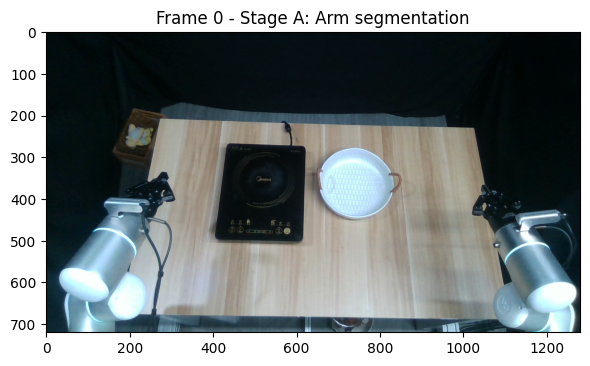

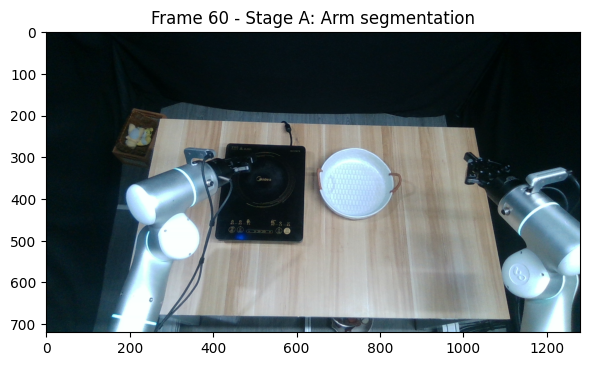

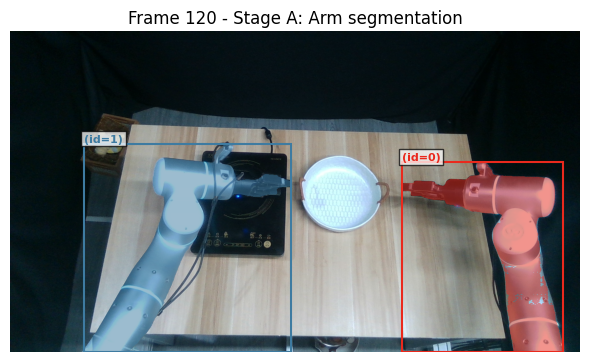

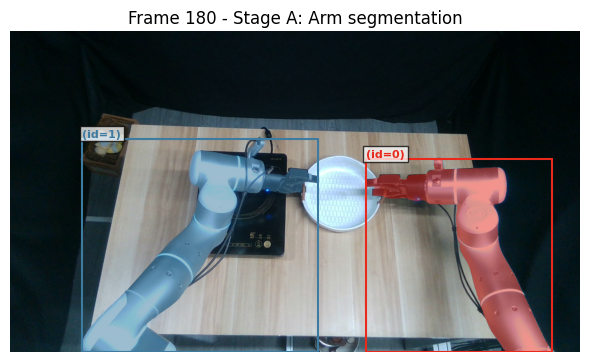

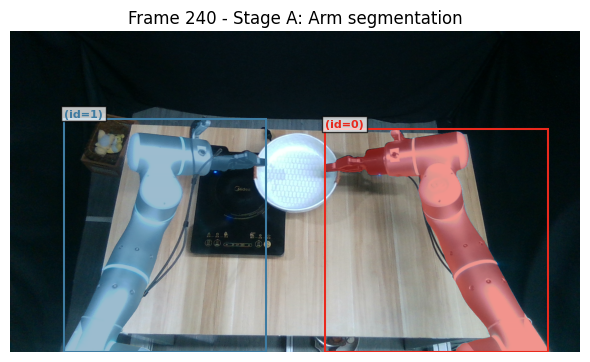

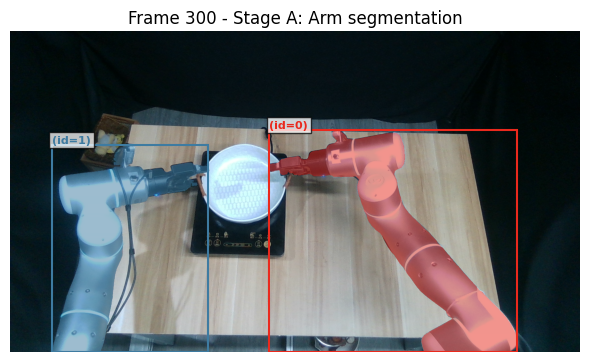

In [5]:
visualize_outputs(
    outputs_per_frame=outputs_stage_a,
    video_frames=video_frames_for_vis,
    stride=VIS_FRAME_STRIDE,
    max_plots=VIS_MAX_PLOTS,
    title="Stage A: Arm segmentation",
)

## 3) 阶段 B：关键帧 points 新增 gripper（全新 obj_id）并再次传播

In [6]:
print(f"[stage B] GRIPPER_OBJ_ID={GRIPPER_OBJ_ID}")
print("[stage B] injecting gripper prompts...")
apply_prompt_list(
    predictor_obj=predictor,
    session_id_value=session_id,
    prompt_list=gripper_prompts_norm,
    stage_name="stage B",
)

print(f"[stage B] propagating direction={PROPAGATION_DIRECTION_STAGE_B} ...")
outputs_stage_b = propagate_in_video(
    predictor_obj=predictor,
    session_id_value=session_id,
    propagation_direction=PROPAGATION_DIRECTION_STAGE_B,
)
print(f"[stage B] done, frame outputs={len(outputs_stage_b)}")

[stage B] GRIPPER_OBJ_ID=2
[stage B] injecting gripper prompts...
[stage B] add_prompt done | frame=120 obj_id=2 points=2
[stage B] propagating direction=forward ...


  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

 97%|█████████▋| 225/233 [00:10<00:00, 21.57it/s]

[stage B] done, frame outputs=233


100%|██████████| 233/233 [00:10<00:00, 21.24it/s]


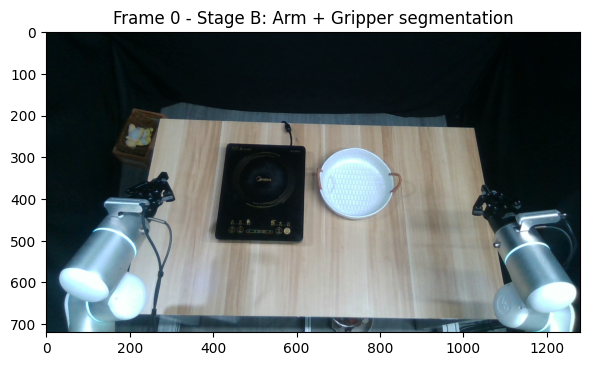

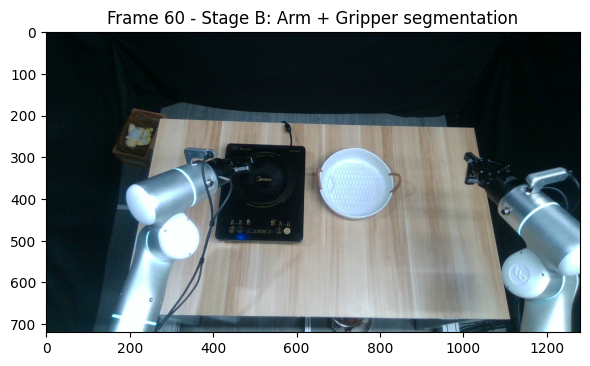

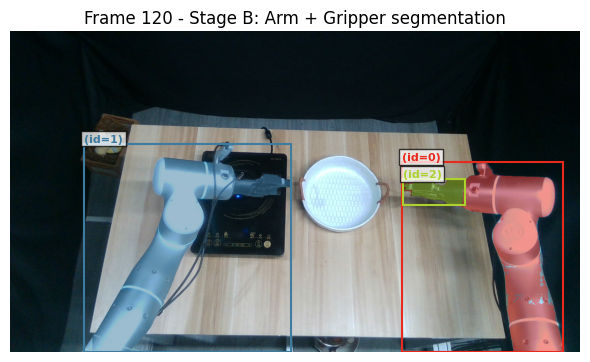

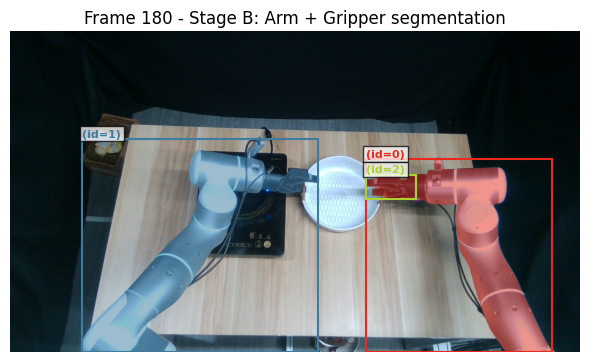

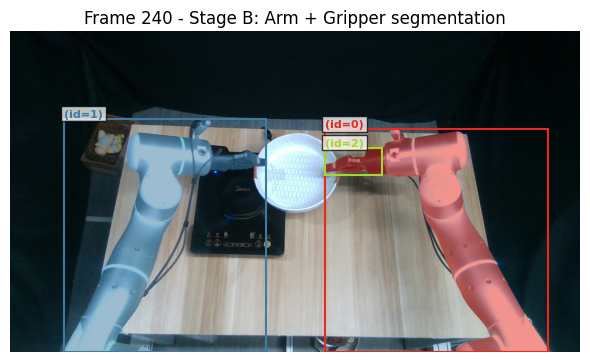

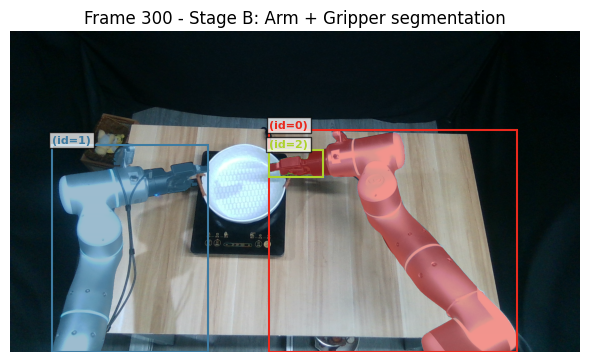

In [7]:
visualize_outputs(
    outputs_per_frame=outputs_stage_b,
    video_frames=video_frames_for_vis,
    stride=VIS_FRAME_STRIDE,
    max_plots=VIS_MAX_PLOTS,
    title="Stage B: Arm + Gripper segmentation",
)

## 4) 导出 mask（支持 arm-only / gripper-only / union / custom）

In [ ]:
export_obj_ids = resolve_export_obj_ids(
    export_mode=EXPORT_MODE,
    arm_obj_ids=ARM_OBJ_IDS,
    gripper_obj_id=GRIPPER_OBJ_ID,
    custom_obj_ids=EXPORT_CUSTOM_OBJ_IDS,
)

print(f"[export] EXPORT_MODE={EXPORT_MODE}, resolved_obj_ids={export_obj_ids}")

mask_paths = save_masks_for_propainter(
    outputs_per_frame=outputs_stage_b,
    video_frames=video_frames_for_vis,
    output_dir=EXPORT_OUTPUT_DIR,
    target_obj_ids=export_obj_ids,
    dilate_radius=EXPORT_DILATE_RADIUS,
)

print(f"[export] sample: first={mask_paths[0] if mask_paths else 'N/A'}")
print(f"[export] sample: last={mask_paths[-1] if mask_paths else 'N/A'}")

## 5) 资源清理（session close + predictor shutdown + 进程组清理）

In [ ]:
cleanup_resources(
    predictor_obj=predictor,
    session_id_value=session_id,
)

predictor = None
session_id = None
print("[cleanup] globals reset done")